# EMCal clustering with Tensorflow/Keras

## 1. Preprocess data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import uproot

In [3]:
N = 20000

file = uproot.open('data/merged_20000_evts.root')
tree = file['ttree']


pid = tree['truthpar_id'].array(library='np', entry_stop=N)
px = tree['truthpar_px'].array(library='np', entry_stop=N)
py = tree['truthpar_py'].array(library='np', entry_stop=N)
pz = tree['truthpar_pz'].array(library='np', entry_stop=N)

pid = np.concatenate(pid,axis=0)
pid = (pid == 22).astype(int)

px = np.concatenate(px,axis=0)
py = np.concatenate(py,axis=0)
pz = np.concatenate(pz,axis=0)

In [4]:
pt = []
eta = []
phi = []

for i in range(N):
    pt.append(np.sqrt(px[i]*px[i]+py[i]*py[i]+pz[i]*pz[i]))
    p = np.sqrt(px[i]*px[i]+py[i]*py[i]+pz[i]*pz[i])
    eta.append(0.5 * np.log((p + pz[i]) / (p - pz[i])))
    phi.append(np.arctan2(py[i],px[i]))
    
pt = np.array(pt)
eta = np.array(eta)
phi = np.array(phi)

In [5]:
e_tow = tree['emcalen'].array(library='np', entry_stop=N)
eta_tow = tree['emcalet'].array(library='np', entry_stop=N)
phi_tow = tree['emcalph'].array(library='np', entry_stop=N)

In [6]:
eta_values = set()

for et in eta_tow:
    eta_values = eta_values.union(set(et))
    
eta_values = list(eta_values)
eta_values.sort()

eta_dict = dict()

for i,et in enumerate(eta_values):
    eta_dict[et] = i

In [7]:
phi_values = set()

for ph in phi_tow:
    phi_values = phi_values.union(set(ph))
    
phi_values = list(phi_values)
phi_values.sort()

phi_dict = dict()

for i,ph in enumerate(phi_values):
    phi_dict[ph] = i

In [8]:
ieta_tow = []
iphi_tow = [] 

for et,ph in zip(eta_tow,phi_tow):
    ieta_event = []
    iphi_event = []
    for e,p in zip(et,ph):
        ieta_event.append(eta_dict[e])
        iphi_event.append(phi_dict[p])
    ieta_tow.append(np.array(ieta_event))
    iphi_tow.append(np.array(iphi_event))
    
ieta_tow = np.array(ieta_tow,dtype=object)
iphi_tow = np.array(iphi_tow,dtype=object)

In [9]:
seed_e = np.zeros(N)
seed_eta = np.zeros(N)
seed_ieta = np.zeros(N,dtype=int)
seed_phi = np.zeros(N)
seed_iphi = np.zeros(N,dtype=int)

nmax_e = np.zeros(N)
nmax_eta = np.zeros(N)
nmax_ieta = np.zeros(N,dtype=int)
nmax_phi = np.zeros(N)
nmax_iphi = np.zeros(N,dtype=int)

i = 0
for e,et,ph in zip(e_tow,eta_tow,phi_tow):
    e_copy = e.copy()
    e_copy.sort()
    seed_e[i] = e_copy[-1]
    seed_index = list(e).index(seed_e[i])
    seed_eta[i] = et[seed_index]
    seed_ieta[i] = eta_dict[seed_eta[i]]
    seed_phi[i] = ph[seed_index]
    seed_iphi[i] = phi_dict[seed_phi[i]]
    
    nmax_e[i] = e_copy[-2]
    nmax_index = list(e).index(nmax_e[i])
    nmax_eta[i] = et[nmax_index]
    nmax_ieta[i] = eta_dict[nmax_eta[i]]
    nmax_phi[i] = ph[nmax_index]
    nmax_iphi[i] = phi_dict[nmax_phi[i]]
    
    i += 1

In [42]:
clusters = np.zeros((N,25),dtype=float)
clusters7x7 = np.zeros((N,49),dtype=float)
clusters9x9 = np.zeros((N,81),dtype=float)
clusters19x19 = np.zeros((N,19*19),dtype=float)

clusters9x9_2d = np.zeros((N,9,9),dtype=float)
clusters19x19_2d = np.zeros((N,19,19),dtype=float)

for i in range(N):
    if seed_e[i] < 0.1 or seed_ieta[i] < 2 or seed_ieta[i] > 93:
        continue
    
    for iet in range(0,5):
        for iph in range(0,5):
            index = np.where((ieta_tow[i] == iet+seed_ieta[i]-2) & (iphi_tow[i] == (iph+seed_iphi[i]-2) % 256))[0]
            if len(index) == 1:
                clusters[i][iet + iph*5] = e_tow[i][index]/seed_e[i]
            else:
                clusters[i][iet + iph*5] = 0            
     
    for iet in range(0,7):
        for iph in range(0,7):
            index = np.where((ieta_tow[i] == iet+seed_ieta[i]-3) & (iphi_tow[i] == (iph+seed_iphi[i]-3) % 256))[0]
            if len(index) == 1:
                clusters7x7[i][iet + iph*7] = e_tow[i][index]/seed_e[i]
            else:
                clusters7x7[i][iet + iph*7] = 0
                
    for iet in range(0,9):
        for iph in range(0,9):
            index = np.where((ieta_tow[i] == iet+seed_ieta[i]-4) & (iphi_tow[i] == (iph+seed_iphi[i]-4) % 256))[0]
            if len(index) == 1:
                clusters9x9[i][iet + iph*9] = e_tow[i][index]/seed_e[i]
                clusters9x9_2d[i][iet][iph] = e_tow[i][index]/seed_e[i]
            else:
                clusters9x9[i][iet + iph*9] = 0
                clusters9x9_2d[i][iet][iph] = 0
                
    for iet in range(0,19):
        for iph in range(0,19):
            index = np.where((ieta_tow[i] == iet+seed_ieta[i]-9) & (iphi_tow[i] == (iph+seed_iphi[i]-9) % 256))[0]
            if len(index) == 1:
                clusters19x19[i][iet + iph*19] = e_tow[i][index]/seed_e[i]
                clusters19x19_2d[i][iet][iph] = e_tow[i][index]/seed_e[i]
            else:
                clusters19x19[i][iet + iph*19] = 0
                clusters19x19_2d[i][iet][iph] = 0

In [48]:
condition = (seed_e > 0.1) & (seed_ieta > 8) & (seed_ieta < 88)
pidNN_cleaned = pid[np.where(condition)[0]]
clusters5x5_cleaned = clusters[np.where(condition)[0]]
clusters7x7_cleaned = clusters7x7[np.where(condition)[0]]
clusters9x9_cleaned = clusters9x9[np.where(condition)[0]]
clusters19x19_cleaned = clusters19x19[np.where(condition)[0]]

clusters9x9_2d_cleaned = clusters9x9_2d[np.where(condition)[0]]
clusters19x19_2d_cleaned = clusters19x19_2d[np.where(condition)[0]]

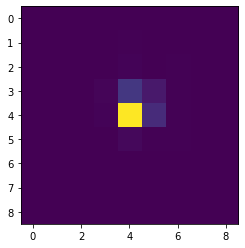

In [46]:
plt.imshow(clusters9x9_2d_cleaned[0])

## 2. Build Keras model

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [14]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models

2022-09-29 17:35:24.124205: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [62]:
model = models.Sequential(
    [
        keras.Input(shape=(9*9,)),
        layers.Dense(16,activation="relu"),
        layers.Dense(16,activation="relu"),
        layers.Dense(1, activation='sigmoid')
    ]

)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

## 3. Test Keras model

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(clusters9x9_cleaned, pidNN_cleaned, test_size=0.33, random_state=42)

model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.1)

Epoch 1/50
296/296 [==============================] - 1s 1ms/step - loss: 0.6338 - accuracy: 0.6765 - val_loss: 0.5539 - val_accuracy: 0.7464
Epoch 2/50
296/296 [==============================] - 0s 1ms/step - loss: 0.5032 - accuracy: 0.7788 - val_loss: 0.4780 - val_accuracy: 0.7778
Epoch 3/50
296/296 [==============================] - 0s 1ms/step - loss: 0.4582 - accuracy: 0.8063 - val_loss: 0.4358 - val_accuracy: 0.8167
Epoch 4/50
296/296 [==============================] - 0s 1ms/step - loss: 0.4304 - accuracy: 0.8221 - val_loss: 0.4092 - val_accuracy: 0.8281
Epoch 5/50
296/296 [==============================] - 0s 1ms/step - loss: 0.4083 - accuracy: 0.8335 - val_loss: 0.3876 - val_accuracy: 0.8329
Epoch 6/50
296/296 [==============================] - 0s 1ms/step - loss: 0.3907 - accuracy: 0.8443 - val_loss: 0.3670 - val_accuracy: 0.8490
Epoch 7/50
296/296 [==============================] - 0s 1ms/step - loss: 0.3738 - accuracy: 0.8503 - val_loss: 0.3507 - val_accuracy: 0.8632
Epoch 

In [64]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 857us/step - loss: 0.2876 - accuracy: 0.9022


[0.2875981032848358, 0.9021990895271301]

In [65]:
from sklearn import metrics

fpr_dnn, tpr_dnn, thresholds = metrics.roc_curve(y_test, model.predict(X_test))

162/162 [==============================] - 0s 626us/step


## 4. Convolutional neural network models

In [51]:
model2 = keras.Sequential(
    [
        keras.Input(shape=(19,19,1)),
        layers.Conv2D(30, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(15, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(64),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [52]:
X_train, X_test, y_train, y_test = train_test_split(clusters19x19_2d_cleaned, pidNN_cleaned, test_size=0.33, random_state=42)

model2.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.1)

Epoch 1/50
296/296 [==============================] - 3s 10ms/step - loss: 0.5547 - accuracy: 0.7243 - val_loss: 0.4465 - val_accuracy: 0.8129
Epoch 2/50
296/296 [==============================] - 3s 10ms/step - loss: 0.4226 - accuracy: 0.8264 - val_loss: 0.3630 - val_accuracy: 0.8727
Epoch 3/50
296/296 [==============================] - 3s 9ms/step - loss: 0.3685 - accuracy: 0.8609 - val_loss: 0.3221 - val_accuracy: 0.8813
Epoch 4/50
296/296 [==============================] - 3s 10ms/step - loss: 0.3472 - accuracy: 0.8725 - val_loss: 0.2855 - val_accuracy: 0.8936
Epoch 5/50
296/296 [==============================] - 3s 10ms/step - loss: 0.3265 - accuracy: 0.8815 - val_loss: 0.2832 - val_accuracy: 0.9031
Epoch 6/50
296/296 [==============================] - 3s 10ms/step - loss: 0.3099 - accuracy: 0.8904 - val_loss: 0.2796 - val_accuracy: 0.9022
Epoch 7/50
296/296 [==============================] - 3s 10ms/step - loss: 0.2980 - accuracy: 0.8938 - val_loss: 0.2722 - val_accuracy: 0.9098


In [53]:
model2.evaluate(X_test, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.2642 - accuracy: 0.9292


[0.2642357051372528, 0.9292052388191223]

In [54]:
fpr_cnn, tpr_cnn, thresholds = metrics.roc_curve(y_test, model2.predict(X_test))

162/162 [==============================] - 0s 2ms/step


DNN:
pi0 rejection rate at 90% photon efficiency: 0.897138437741686
photon rejection rate at 90% pi0 efficiency: 0.8814472671285605

CNN:
pi0 rejection rate at 90% photon efficiency: 0.9323279195668986
photon rejection rate at 90% pi0 efficiency: 0.9615088529638183


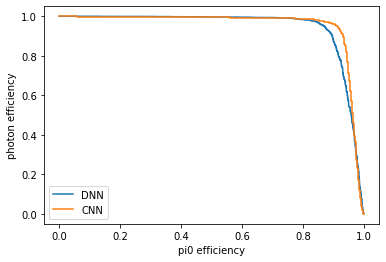

In [69]:
plt.plot(1-fpr_dnn,tpr_dnn,label="DNN")
plt.plot(1-fpr_cnn,tpr_cnn,label="CNN")
plt.xlabel("pi0 efficiency")
plt.ylabel("photon efficiency")
plt.legend();

print("DNN:")
print("pi0 rejection rate at 90% photon efficiency:",np.interp(0.9,tpr_dnn,1-fpr_dnn))
print("photon rejection rate at 90% pi0 efficiency:",np.interp(0.1,fpr_dnn,tpr_dnn))
print("")
print("CNN:")
print("pi0 rejection rate at 90% photon efficiency:",np.interp(0.9,tpr_cnn,1-fpr_cnn))
print("photon rejection rate at 90% pi0 efficiency:",np.interp(0.1,fpr_cnn,tpr_cnn))